In [28]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread

import tensorflow as tf
import tensorflow_hub as hub
print('Tensorflow version:', tf.__version__)
print('Tensorflow Hub version:', hub.__version__)

#Check GPU access
print("GPU access:", "available :)" if tf.config.list_physical_devices('GPU') else "not available :(")

Tensorflow version: 2.10.0
Tensorflow Hub version: 0.16.1
GPU access: available :)


In [29]:
## Get the file paths
fake_files = os.listdir("C:\\Users\\punee\\OneDrive\\Desktop\\test images\\fake") 
real_files = os.listdir("C:\\Users\\punee\\OneDrive\\Desktop\\test images\\real") 

fake_paths = ["C:\\Users\\punee\\OneDrive\\Desktop\\test images\\fake\\" + file for file in fake_files]
real_paths = ["C:\\Users\\punee\\OneDrive\\Desktop\\test images\\real\\" + file for file in real_files]
all_paths = fake_paths + real_paths

targets = []
targets += [1] * len(fake_paths)
targets += [0] * len(real_paths)

data = pd.DataFrame(columns=['id', 'target'])
data['id'] = all_paths
data['target'] = targets

np.random.seed(42)
data = data.sample(frac=1).reset_index(drop=True)

X = data['id']
Y = data['target']

In [30]:
IMG_SIZE = 224 # required image size for the pretrained model

def process_image(filepath, img_size=IMG_SIZE):
  image = tf.io.read_file(filepath) #read the file to a tensor (long tensor string)
  image = tf.image.decode_jpeg(image, channels=3) #convert the file into a integer tensor with 3 color channels
  image = tf.image.convert_image_dtype(image, dtype=tf.float32) # normalize the data from 0-255 to 0-1 by converting dtype to float
  image = tf.image.resize(image, size=(img_size, img_size)) # resize image to required resolution
  return image

def get_image_and_label(filepath, label): # helper function to get a pair of image and label tensors
  return process_image(filepath), label

In [31]:
BATCH_SIZE = 32

def create_batches(X, Y, batch_size=BATCH_SIZE):
    '''
        Creates batches of data out of given image and label pairs.
    '''
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # file paths
                                               tf.constant(Y))) # labels
    data_batch = data.map(get_image_and_label).batch(BATCH_SIZE)
    # converts file path and label pair tensors into image and label
    # pair tensors and then into batches
    return data_batch

In [18]:
test_data = create_batches(X, Y)

In [19]:
def save_model(model, suffix=None):
    model_dir = os.path.join('C:\\Users\\punee\\MLProjs\\DeepFake\\models',
                          datetime.datetime.now().strftime('%d_%m_%Y_%H_%M_%S'))
    model_path = model_dir + '-' + suffix + '.h5'
    print('Saving the model to {}'.format(model_path))
    model.save(model_path)
    return model_path
    
def load_model(model_path):
    print('Loading the model from path: {}'.format(model_path))
    model = tf.keras.models.load_model(model_path,
                               custom_objects={'KerasLayer' : hub.KerasLayer})
    return model

In [20]:
model = load_model("C:/Users/punee/MLProjs/DeepFake/models/18_04_2024_23_21_03-All-Images-ResNetV2-Adam.h5")

Loading the model from path: C:/Users/punee/MLProjs/DeepFake/models/18_04_2024_23_21_03-All-Images-ResNetV2-Adam.h5


In [21]:
test_preds = model.predict(test_data)

1/1 [==============================] - 1s 1s/step


In [22]:
test_preds

array([[0.2699792 ],
       [0.99908185],
       [0.7579952 ],
       [0.9983815 ],
       [0.46050507],
       [0.9501712 ],
       [0.0949811 ],
       [0.33466375],
       [0.5755775 ],
       [0.20012577]], dtype=float32)

In [23]:
def unbatchify(data):
  images = []
  labels = []
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(label)
  return images, labels

In [24]:
test_images, test_labels = unbatchify(test_data)

In [25]:
def plot_pred(prediction_probs, val_images, val_labels, n=1): # val_labels are true labels

    prediction_prob, val_image, val_label = prediction_probs[n], val_images[n], val_labels[n] # get each value from arrays

    pred_label = 1 if prediction_prob > 0.5 else 0

    plt.imshow(val_image)

    plt.xticks([]) # remove axis markings
    plt.yticks([])

    if pred_label == val_label:
        c = "green"
    else:
        c = "red"

    plt.title('prediction = {}, activation = {:2.2f}%, actual = {}'.format(
        "deepfake" if pred_label == 1 else "real",
        np.max(prediction_prob) * 100,
        "deepfake" if val_label == 1 else "real"),
        color=c
    )

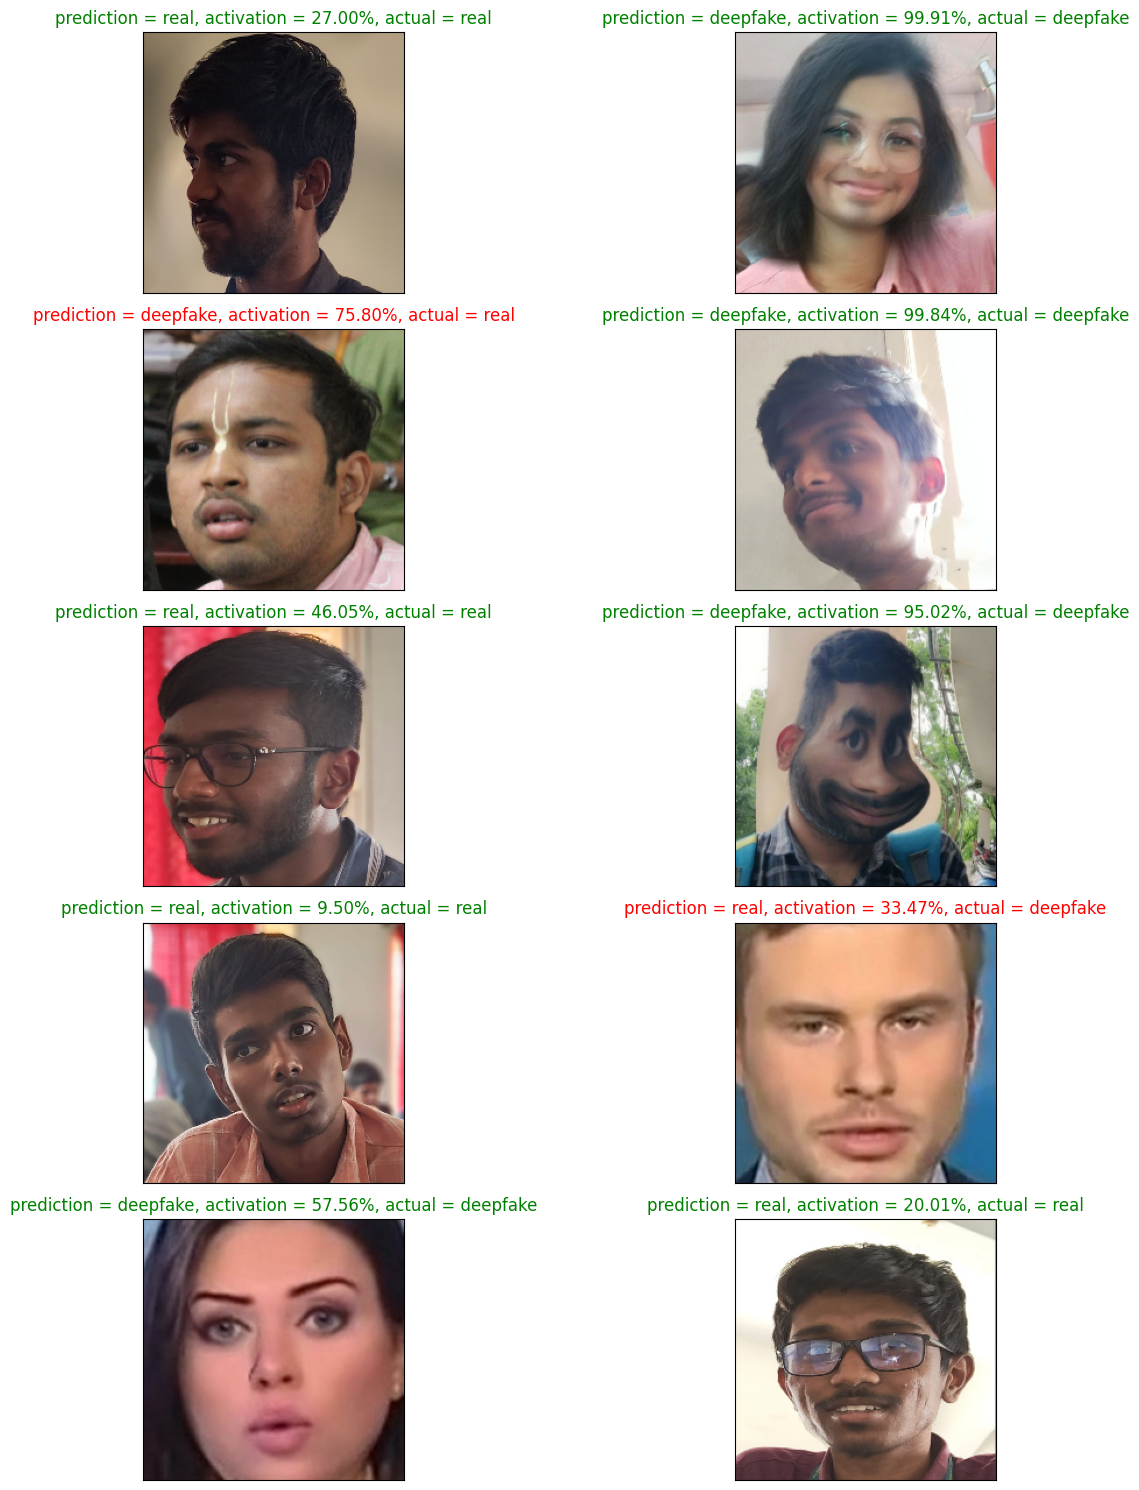

In [32]:
i_shift = 0
num_rows = 5
num_cols = 2
num_total = num_rows * num_cols
plt.figure(figsize=(6*num_cols, 3*num_rows))
for i in range(num_total):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_pred(test_preds, test_images, test_labels, n=i+i_shift)
plt.tight_layout(h_pad=1.0)